# &#x1F4D1; &nbsp; P0: Titanic Survival Exploration (the third version)
the first version: https://olgabelitskaya.github.io/Data_Analyst_ND_Project2.html

the second version: https://olgabelitskaya.github.io/MLE_ND_P0_V0.html

## 1.  References
### Dataset
In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive. 

The data contains demographics and voyage information from 891 of the 2224 passengers and crew on board the ship.

This link allows reading the description of this dataset on the Kaggle website, where the data was obtained. https://www.kaggle.com/c/titanic/data

### Resources :
Intro to Data Science. Udacity: https://www.udacity.com/course/intro-to-data-science--ud359

Statistics in Python. Scipy Lecture Notes: http://www.scipy-lectures.org/packages/statistics/index.html

A Visual Introduction to Machine Learning: http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

The scikit-learn metrics: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

## 2. Code Tools

In [1]:
#########################
### IMPORT  LIBRARIES ###
######################### 
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt

from IPython.display import display 
  
# Pretty display for notebooks
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
from matplotlib import style
%matplotlib inline

########################
### EXTRA  LIBRARIES ###
########################
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Convolution1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


##  3. Statistical Analysis  and   Data   Exploration
### 3.1 Dataset
Let's extract the data from the .csv file, create a  pandas DataFrame and look at the available indicators:

- ***Survived***: Outcome of survival (0 = No; 1 = Yes)
- ***Pclass***: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- ***Name***: Name of passenger
- ***Sex***: Sex of the passenger
- ***Age***: Age of the passenger (Some entries contain NaN)
- ***SibSp***: Number of siblings and spouses of the passenger aboard
- ***Parch***: Number of parents and children of the passenger aboard
- ***Ticket***: Ticket number of the passenger
- ***Fare***: Fare paid by the passenger
- ***Cabin***: Cabin number of the passenger (Some entries contain NaN)
- ***Embarked***: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

In [2]:
# Load the dataset
train_file = 'titanic_train.csv'
test_file = 'titanic_test.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
full_data = train_data.append(test_data, ignore_index=True)
# Success
print ("The Titanic dataset has {} data points with {} variables.".format(*full_data.shape))

The Titanic dataset has 1309 data points with 12 variables.


In [3]:
print ("Examples of Data Points")
display(test_data[:3].T)

Examples of Data Points


,0,1,2
PassengerId,892,893,894
Pclass,3,3,2
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis"
Sex,male,female,male
Age,34.5,47,62
SibSp,0,1,0
Parch,0,0,0
Ticket,330911,363272,240276
Fare,7.8292,7,9.6875
Cabin,NaN,NaN,NaN


### 3.2 Survived
The next step is removing the Survived feature from the data and storing it separately as our prediction targets.

The passenger data and the outcomes of survival are now paired. That means for any passenger **all_features.loc[i]**, they have the survival **outcomes[i]**.

In [4]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = train_data['Survived']
all_features = train_data.drop('Survived', axis = 1)
 
print ("The percentage of survived passengers: {:.2f}%".format(100*outcomes.mean()))

The percentage of survived passengers: 38.38%


### 3.3 Accuracy Score
To measure the performance of our predictions, we need metrics to score our predictions against the true outcomes of survival.

- 1) The built function **accuracy_score_0()** calculates the proportion of passengers where our prediction of their survival is correct.
- 2) Functions *sklearn.metrics*: 
- **recall_score**, 
- **accuracy_score**, 
- **precision_score**, 
- **f1_score**,
- **make_scorer**.

In [5]:
def accuracy_score_0(truth, pred):         
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred):         
        # Calculate and return the accuracy as a percent
        return ("Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100))    
    else:
        return ("Number of predictions does not match number of outcomes!")

## 4. Making   Prediction
### 4.1 Intuitive Predictions
If we were asked to make a prediction about any passenger aboard the RMS Titanic whom we knew nothing about, then the best prediction we could make would be that they did not survive. This is because we can assume that a majority of the passengers (more than 50%) did not survive the ship sinking.

The **predictions_0()** function below will always predict that a passenger did not survive. Let's check its accuracy.

In [6]:
def predictions_0(data):
    """ Model with no features. Always predicts a passenger did not survive. """
    predictions = []
    for _, passenger in data.iterrows():        
        # Predict the survival of 'passenger'
        predictions.append(0)    
    # Return our predictions
    return pd.Series(predictions)
# Make the predictions that a passenger did not survive
predictions = predictions_0(all_features) 
# Check accuracy
accuracy_score_0(outcomes, predictions)

'Predictions have an accuracy of 61.62%.'

Now let us check the feature "**Sex**", the outcomes "**Survived**" and their possible dependence. 

Here is a special database for these categories including the indicators in percentages:

- "**Survived by sex in percentages I**" determines the percentage of survived passengers of this sex in relation to the total number of survivors; 
- "**Survived by sex in percentages II**" - the percentage of survived passengers of this sex in relation to the total number of passengers of the same sex.

In [7]:
# Groups by sex
number_by_sex = pd.Series(train_data.groupby('Sex').count()['PassengerId'])
survived_by_sex = pd.Series(train_data.groupby('Sex').sum()['Survived'])

def percent_xy(x,y):
    return round(100.0*x/y, 2)

# Count percentages
number_by_sex_in_per = pd.Series(percent_xy(number_by_sex, len(train_data)))
survived_by_sex_in_per1 = pd.Series(percent_xy(survived_by_sex, outcomes.sum()))
survived_by_sex_in_per2 = pd.Series(percent_xy(survived_by_sex, number_by_sex))
sex_data = pd.DataFrame({'Number by sex': number_by_sex,
                         'Number by sex in percentages':number_by_sex_in_per,
                         'Survived by sex':survived_by_sex,
                         'Survived by sex in percentages I':survived_by_sex_in_per1,
                         'Survived by sex in percentages II':survived_by_sex_in_per2})
sex_data

,Number by sex,Number by sex in percentages,Survived by sex,Survived by sex in percentages I,Survived by sex in percentages II
Sex,,,,,
female,314,35.24,233,68.13,74.20
male,577,64.76,109,31.87,18.89


Combining the data in one histogram clearly shows the tendency: female passengers were more likely to survive in this instance.

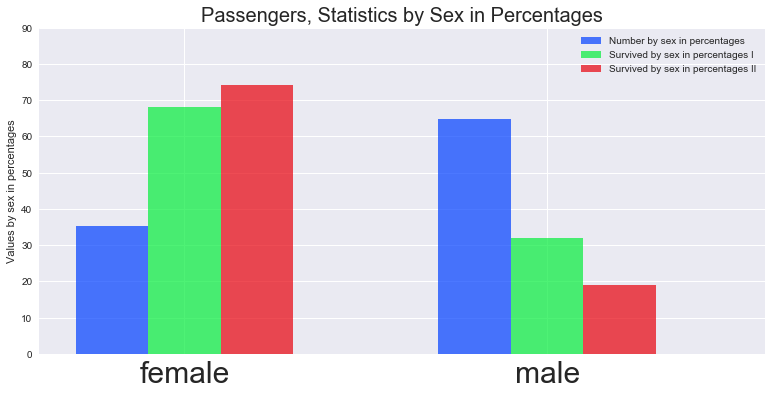

In [8]:
# plot parameters
plt.rcParams['figure.figsize'] = (13, 6)
style.use('seaborn-bright')
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.array([1,2])           # the x locations for the indicator
width = 0.2                     # the width of the bars

## Bars
rects1 = ax.bar(ind, number_by_sex_in_per, width, alpha = 0.7)
rects2 = ax.bar(ind+width, survived_by_sex_in_per1, width, alpha = 0.7)
rects3 = ax.bar(ind+2*width, survived_by_sex_in_per2, width, alpha = 0.7)

# Axes and labels
ax.set_xlim(-width+1,len(ind)+width+0.6)
ax.set_ylim(0,90)
ax.set_ylabel('Values by sex in percentages')
ax.set_title('Passengers, Statistics by Sex in Percentages', fontsize=20)
xTickMarks = ['female','male']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=0, fontsize=30)

## Legend
ax.legend((rects1[0], rects2[0], rects3[0]), 
          ('Number by sex in percentages', 
           'Survived by sex in percentages I', 
           'Survived by sex in percentages II'))

Let's build on our previous prediction: If a passenger was female, then we will predict that they survived. Otherwise, we will predict the passenger did not survive.

In [9]:
def predictions_1(data):
    """ Model with one feature: 
            - Predict a passenger survived if they are female. """
    
    predictions = []
    for _, passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions 
predictions1 = predictions_1(all_features) 
# Check accuracy
accuracy_score_0(outcomes, predictions1)

'Predictions have an accuracy of 78.68%.'

Using just the Sex feature for each passenger, we are able to increase the accuracy of our predictions by a significant margin.
Now, let's consider using an additional feature to see if we can further improve our predictions. We will start by looking at the Age.

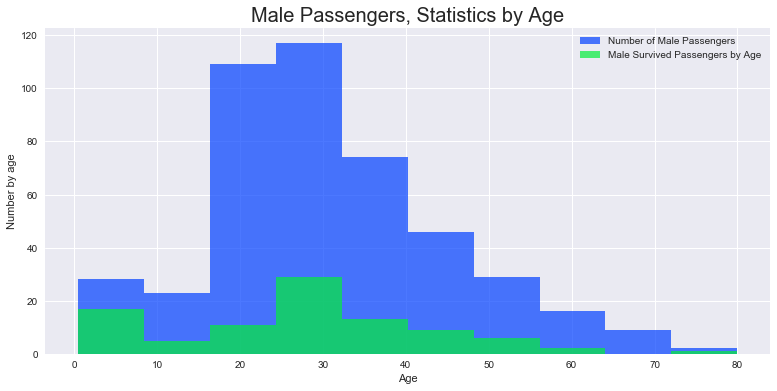

In [10]:
# Data for male passengers
male = train_data[train_data.Sex=='male']
male.Age.hist(alpha=0.7)
male[male.Survived==1].Age.hist(alpha=0.7)

# Labels, title, legend
plt.xlabel("Age")
plt.ylabel("Number by age")
plt.title("Male Passengers, Statistics by Age", fontsize=20)
plt.legend(["Number of Male Passengers", 
           "Male Survived Passengers by Age"])

In [11]:
def predictions_2(data):
    """ Model with two features: 
            - Predict a passenger survived if they are female.
            - Predict a passenger survived if they are male and younger than 10. """
    
    predictions = []
    for _, passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Sex'] == 'male' and passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)
# Make the predictions 
predictions2 = predictions_2(all_features) 
# Check accuracy
accuracy_score_0(outcomes, predictions2)

'Predictions have an accuracy of 79.35%.'

Adding the feature **Age** as a condition in conjunction with **Sex** improves the accuracy by a small margin more than with simply using the feature **Sex** alone. Now we can try to find a series of features and conditions to split the data on to obtain an outcome prediction accuracy of at least 80%. This may require multiple features and multiple levels of conditional statements to succeed. We can use the same feature multiple times with different conditions.

There are some experiments and the function **prediction_final()** as a result:

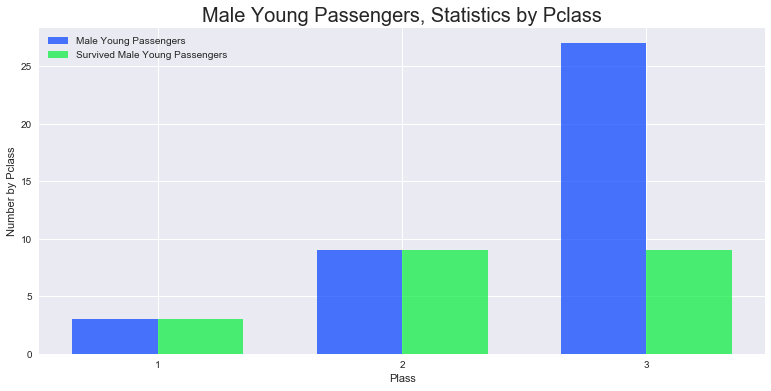

In [13]:
# Data for male and young passengers
young_male = male[male.Age < 15]
survived_young_male = young_male[young_male.Survived==1]

# Create histogram
plt.hist((young_male.Pclass, survived_young_male.Pclass), 
          bins=range(1,5), rwidth=0.7, alpha=0.7, align='left')

# Ticks, labels, title, legend
plt.xticks([1,2,3])
plt.xlabel("Plass")
plt.ylabel("Number by Pclass")
plt.title("Male Young Passengers, Statistics by Pclass", fontsize=20)
plt.legend(["Male Young Passengers", "Survived Male Young Passengers"])

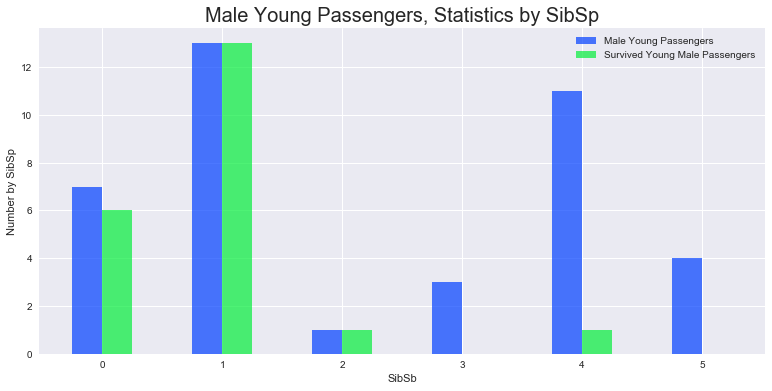

In [14]:
# Create histogram
plt.hist((young_male.SibSp, survived_young_male.SibSp), 
         bins=range(0,7), rwidth=0.5, align='left', alpha=0.7)

# Labels, title, legend
plt.xlabel("SibSb")
plt.ylabel("Number by SibSp")
plt.title("Male Young Passengers, Statistics by SibSp", fontsize=20)
plt.legend(["Male Young Passengers", "Survived Young Male Passengers"])

In [15]:
def predictions_final(data):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    
    predictions = []
    for _, passenger in data.iterrows():
        if (passenger['Sex'] == 'female'):
            predictions.append(1)
                
        elif passenger['Pclass'] in [1,2] and (passenger['Age'] < 16 or passenger['Age'] > 75):
            predictions.append(1)
            
        elif passenger['Age'] < 15 and passenger['SibSp'] < 3:
            predictions.append(1)
            
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)
# Make the predictions 
predictions_final = predictions_final(all_features) 
# Check accuracy
accuracy_score_0(outcomes, predictions_final)

'Predictions have an accuracy of 80.92%.'

The final set of features **Sex**, **Age**, **SibSp** and **Pclass** are the most informative on my opinion.

As we noted the percentage of survivors of passengers is much higher among women than among men, and it was used in our predictions.

Next, I proceed from the assumption that because of humanitarian reasons people rescue children and elders at first. Unfortunately, this was only valid for the passengers of the first and second classes in this dataset.

And the latest clarification, which overcomes the border of 80% in prediction accuracy: if a family has more than three children, absolutely all the family may not be survived in catastrophic situations and in an atmosphere of panic.

Let's evaluate the quality of the prediction.

In [16]:
print ("Predictions have an accuracy of {:.2f}%.".format(accuracy_score(outcomes, predictions_final)*100))
print ("Predictions have an recall score equal to {:.2f}%.".format(recall_score(outcomes, 
                                                                                predictions_final)*100))
print ("Predictions have an precision score equal to {:.2f}%.".format(precision_score(outcomes,
                                                                                      predictions_final)*100))

Predictions have an accuracy of 80.92%.
Predictions have an recall score equal to 74.27%.
Predictions have an precision score equal to 75.60%.


The evaluation terminology:

- accuracy = number of  people that  are  correctly  predicted as survived or non-survived / number  of all  people  in  the dataset 
- recall = number of people that are predicted as survived and they are actually survived / number of  people are actually survived
- precision =  number of people that  are predicted as survived  and they are actually survived / number of people that are predicted as survived

In this part of the project, I have used a manual implementation of a simple machine learning model, the decision tree which splits a set of data into smaller and smaller groups (called nodes), by one feature at a time. The predictions become more accurate if each of the resulting subsets is more homogeneous (contain similar labels) than before.

A decision tree is just one of many models that come from supervised learning, i.e. learning a model from labeled training data to make predictions about unseen or future data in a set of samples the desired outputs are already known.

### 4.2 Classifiers
I think this machine learning problem is in the classification field. It needs to predict the labels for the passengers: 'yes' or 'no' for the feature 'Survived'.

For simplicity, the border between regression and classification can be described in this way:

- classification: predict the values of discrete or categorical targets;
- regression: predict the values of continuous targets.

Let's display some important information about the data training set.

In [17]:
# Calculate the number of passengers
n_passengers = len(train_data)

# Calculate the number of features
n_features = len(list(train_data.T.index))

# Number of survived passengers
n_survived = len(train_data[train_data['Survived'] == 1])

# Number of non-survived passengers
n_nonsurvived = len(train_data[train_data['Survived'] == 0])

# Print the results
print ("Total number of passengers: {}".format(n_passengers))
print ("Number of features: {}".format(n_features))
print ("Number of passengers who survived: {}".format(n_survived))
print ("Number of passengers who did not survive: {}".format(n_nonsurvived))
print ("Persentage of survived passengers: {:.2f}%".format(100*n_survived/n_passengers))

# Show the list of columns
print ("\nFeature columns:\n{}".format(list(all_features.columns)))
print ("\nTarget column: 'Survived'")

Total number of passengers: 891
Number of features: 12
Number of passengers who survived: 342
Number of passengers who did not survive: 549
Persentage of survived passengers: 38.38%

Feature columns:
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Target column: 'Survived'


Let's exclude the features that cannot have an influence on the target and the feature **Cabin** that has too many **NaN** values.

In [276]:
# Count nan values for the feature 'Cabin'
n_nan_cabin = pd.isnull(all_features['Cabin']).sum()
print (" Persentage of NaN values in 'Cabin': {:.2f}%".format(100.0*n_nan_cabin/n_passengers))
# Setup a new feature list
feature_list2 = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
pre_features = all_features[feature_list2]
test_features = test_data[feature_list2]

 Persentage of NaN values in 'Cabin': 77.10%


In [277]:
pre_features.head(11).T

,0,1,2,3,4,5,6,7,8,9,10
Pclass,3,1,3,1,3,3,1,3,3,2,3
Sex,male,female,female,female,male,male,male,male,female,female,female
Age,22,38,26,35,35,NaN,54,2,27,14,4
SibSp,1,1,0,1,0,0,0,3,0,1,1
Parch,0,0,0,0,0,0,0,1,2,0,1
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,16.7
Embarked,S,C,S,S,S,Q,S,S,S,C,S


Now I should count missing values for the remained variables.

In [278]:
print ("Number of missing values in the train set\n")
for feature in feature_list2:
    print("{}:{}".format(feature, pd.isnull(pre_features[feature]).sum()))

print('')
    
print ("Number of missing values in the test set\n")
for feature in feature_list2:
    print("{}:{}".format(feature, pd.isnull(test_features[feature]).sum()))

Number of missing values in the train set

Pclass:0
Sex:0
Age:177
SibSp:0
Parch:0
Fare:0
Embarked:2

Number of missing values in the test set

Pclass:0
Sex:0
Age:86
SibSp:0
Parch:0
Fare:1
Embarked:0


As we can see, there are several non-numeric columns that need to be converted. Some of them have simply two values (male/female, 1/0, etc.). These features can be reasonably converted into binary values.

Other columns, like **Embarked**, have more than two values and are known as categorical variables. The recommended way to handle such a column is to create as many columns as possible values and assign a 1 to one of them and 0 to all others.

These generated columns are sometimes called dummy variables, and I will use the **pandas.get_dummies()** function to perform this transformation.

In the preprocessing function, I will also replace found missing values in the features **Age** and **Fare** by the mean and in the feature **Embarked** by the most common value

In [73]:
def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # Replace 'nan' in 'Embarked'
        most_common = pd.get_dummies(X['Embarked']).sum().sort_values(ascending=False).index[0]
        if col == 'Embarked':
            col_data = col_data.replace('nan', most_common)
        
        # Replace 'Nan' in 'Age'
        mean1 = X['Age'].mean()
        if col == 'Age':
            col_data = col_data.replace('NaN', mean1)
            
        # Replace 'Nan' in 'Fare'
        mean2 = X['Fare'].mean()
        if col == 'Fare':
            col_data = col_data.replace('NaN', mean2)
        
        # If data type is non-numeric, replace all male/female, yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['male', 'female'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

Here is the result of applying this function.

In [279]:
pre_features2 = pre_features.copy()
test_features2 = test_features.copy()

pre_features2.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Pclass,3,1,3,1,3,3,1,3,3,2,3,1,3,3,3
Sex,male,female,female,female,male,male,male,male,female,female,female,female,male,male,female
Age,22,38,26,35,35,NaN,54,2,27,14,4,58,20,39,14
SibSp,1,1,0,1,0,0,0,3,0,1,1,0,0,1,0
Parch,0,0,0,0,0,0,0,1,2,0,1,0,0,5,0
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,16.7,26.55,8.05,31.275,7.8542
Embarked,S,C,S,S,S,Q,S,S,S,C,S,S,S,S,S


In [280]:
pre_features2['Sex'].replace({'male' : 1, 'female': 0}, inplace=True)

In [281]:
test_features2['Sex'].replace({'male' : 1, 'female': 0}, inplace=True)

In [282]:
age_mean = pd.concat([pre_features2.Age, test_features2.Age], ignore_index=True).mean()
fare_mean = pd.concat([pre_features2.Fare, test_features2.Fare], ignore_index=True).mean()

most_common = pd.get_dummies(pre_features2['Embarked']).sum().sort_values(ascending=False).index[0]
most_common

'S'

In [283]:
pre_features2['Embarked'] = pre_features2['Embarked'].fillna(most_common)

In [284]:
pre_features2['Age'] = pre_features2['Age'].fillna(age_mean)

In [285]:
test_features2['Age'] = test_features2['Age'].fillna(age_mean)

In [286]:
test_features2['Fare'] = test_features2['Fare'].fillna(fare_mean)

In [287]:
pre_features2.loc[61]

Pclass       1
Sex          0
Age         38
SibSp        0
Parch        0
Fare        80
Embarked     S
Name: 61, dtype: object

In [288]:
pd.isnull(pre_features2).sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [289]:
pd.isnull(test_features2).sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [290]:
pre_features2 = pd.get_dummies(pre_features2, prefix=['Embarked']);

In [291]:
pd.isnull(pre_features2).sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [292]:
test_features2 = pd.get_dummies(test_features2, prefix=['Embarked'], columns=['Embarked']);

In [293]:
pd.isnull(test_features2).sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

For predictions I have chosen the following models:

- GradientBoostingClassifier();
- RandomForestClassifier();
- AdaBoostClassifier().

Let's have a look at their applications and characteristics:

1) **GradientBoostingClassifier**.

- Applications: in the field of learning to rank (for example, web-seach), in ecology.
  - Web-Search Ranking with Initialized Gradient Boosted Regression Trees: http://www.jmlr.org/proceedings/papers/v14/mohan11a/mohan11a.pdf
  - Gradient boosting machines, a tutorial: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/
- Strengths: natural handling of data of mixed type (= heterogeneous features), predictive power, robustness to outliers in output space (via robust loss functions).
- Weaknesses: scalability, due to the sequential nature of boosting it can hardly be parallelized.

2) **RandomForestClassifier**.

- Applications: in ecology, bioinformatics.
  - RANDOM FORESTS FOR CLASSIFICATION IN ECOLOGY: http://onlinelibrary.wiley.com/doi/10.1890/07-0539.1/abstract;jsessionid=AB1864A895F3244AF0699EB0317F2C99.f02t02
  - Random Forest for Bioinformatics: http://www.cs.cmu.edu/~qyj/papersA08/11-rfbook.pdf
- Strengths: runs efficiently on large data bases; gives estimates of what variables are important in the classification; maintains accuracy when a large proportion of the data are missing; high prediction accuracy.
- Weaknesses: difficult to interpret, can be slow to evaluate.

3) **AdaBoostClassifier**.

- Applications: the problem of face detection, text classification, etc.
  - AdaBoost-based face detection for embedded systems: http://www.sciencedirect.com/science/article/pii/S1077314210000871
  - Text Classification by Boosting Weak Learners based on Terms and Concepts: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.443.8019&rep=rep1&type=pdf
- Strengths: can be used with data that is textual, numeric, discrete, etc.; can be combined with any other learning algorithm, not prone to overfitting; simple to implement.
- Weaknesses: can be sensitive to noisy data and outliers; the performance depends on data and weak learner (can fail if weak classifiers too complex).

All these classifiers will produce enough good predictions in this case. We should produce the result with the variant of ranking and it's a well-known fact that classification tends to be a better paradigm for ranking than regression.

Let's initialize three helper functions which we can use for training and testing sets the three supervised learning models we've chosen above.

The functions are as follows:

- **train_classifier** - takes as input a classifier and training data and fits the classifier to the data;
- **predict_labels** - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score;
- **train_predict** - takes as input a classifier, and the training data, and performs train_clasifier and predict_labels.

This function will report the **F1 score** for the training data.

In [294]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".\
           format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))

With the predefined functions above, I will now import the three supervised learning models and run the **train_predict** function for each one. It needs to train and predict on each classifier for three different training set sizes: 200, 400, and all data points. 

Hence,  nine different outputs will be displayed below — three for each model using the varying training set sizes.

In [295]:
# Initialize the three models
clf_A = AdaBoostClassifier()
clf_B = GradientBoostingClassifier()
clf_C = RandomForestClassifier()

# Set up the training set sizes
X_train_200, y_train_200 = pre_features2[:200], outcomes[:200]
X_train_400, y_train_400 = pre_features2[:400], outcomes[:400]
X_train, y_train = pre_features2, outcomes
X_test = test_features2

# Execute the 'train_predict' function for each classifier and each training set size
for clf in [clf_A, clf_B, clf_C]:
    for (X_train, y_train) in [(X_train_200, y_train_200), 
                               (X_train_400, y_train_400), 
                               (X_train, y_train)]:
        train_predict(clf, X_train, y_train)

Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.1183 seconds
Made predictions in 0.0085 seconds.
F1 score for training set: 0.7761.
Training a AdaBoostClassifier using a training set size of 400. . .
Trained model in 0.1162 seconds
Made predictions in 0.0107 seconds.
F1 score for training set: 0.7818.
Training a AdaBoostClassifier using a training set size of 891. . .
Trained model in 0.1239 seconds
Made predictions in 0.0128 seconds.
F1 score for training set: 0.7778.
Training a GradientBoostingClassifier using a training set size of 200. . .
Trained model in 0.0822 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.9474.
Training a GradientBoostingClassifier using a training set size of 400. . .
Trained model in 0.0835 seconds
Made predictions in 0.0016 seconds.
F1 score for training set: 0.8919.
Training a GradientBoostingClassifier using a training set size of 891. . .
Trained model in 0.1097 seconds
Made predictions in 0

The best result has the **RandomForestClassifier** and I will try to apply it for test predictions.

In [296]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(test_features2)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [297]:
submission = pd.DataFrame({"PassengerId": test_data["PassengerId"], "Survived": y_pred})

In [56]:
# submission.to_csv('C:/users/OlgaBelitskaya/submission.csv', index=False)

### 4.2 MLP Neural Networks

In [320]:
pre_features_array = pre_features2.as_matrix()
outcomes_array = outcomes.as_matrix()
test_features_array = test_features2.as_matrix()

X_train2, X_test2, y_train2, y_test2 = train_test_split(pre_features_array, outcomes_array, 
                                                        test_size=0.25, random_state=1)
X_train2.shape, X_test2.shape                                                       

((668, 9), (223, 9))

In [321]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(18, input_dim=9, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(9, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [322]:
mlp_model = mlp_model()

mlp_history = mlp_model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2),
                            epochs=100, batch_size=8, verbose=0)

In [323]:
def loss_plot(fit_history):
    plt.figure(figsize=(14, 6))
    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')
    plt.legend()
    plt.title('Loss Function');  
    
def acc_plot(fit_history):
    plt.figure(figsize=(14, 6))
    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')
    plt.legend()
    plt.title('Accuracy'); 

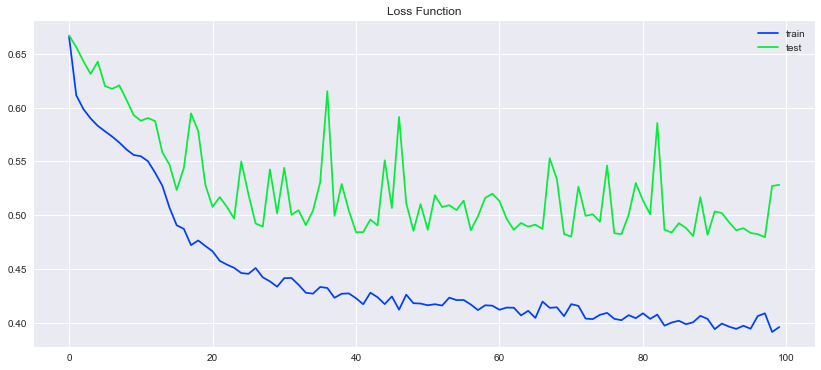

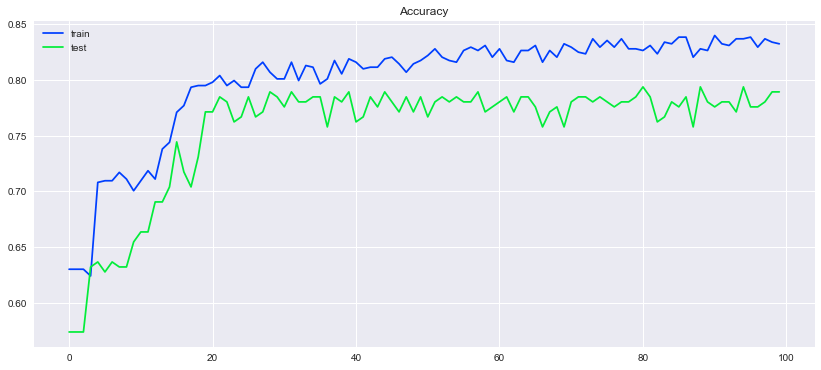

In [324]:
loss_plot(mlp_history)
acc_plot(mlp_history)

In [325]:
mlp_scores = mlp_model.evaluate(X_test2, y_test2, verbose=0)
print("Accuracy: %.2f%%" % (mlp_scores[1]*100))

Accuracy: 78.92%


In [338]:
y_pred_mlp = np.round(mlp_model.predict(test_features_array)).astype(int)
y_pred_mlp[:,0]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [339]:
submission_mlp = pd.DataFrame({"PassengerId": test_data["PassengerId"], "Survived": y_pred_mlp[:,0]})

In [340]:
submission_mlp.to_csv('submission_mlp.csv', index=False)

In [341]:
len(submission_mlp["Survived"])

418

In [342]:
sum(submission_mlp["Survived"]==submission["Survived"])

349

## 5. Conclusion

Overvaluation of meaning and application of machine learning is unlikely to succeed. And the particular supervised method has a special importance because of the possibility of a permanent correlation of the predictions with the result of real actions.

There are several natural ideas for applying the supervised learning.

I. For every catastrophic situation, find out the exact sequence of steps and technical facilities which maximally decrease the damage. On the basis of the identified trends, it is possible to develop and check in practice clear guidelines to save lives and restore economic activities (for example, during and after the floods). Applying the scientific methods, in this case, means thousands of lives and quick recovering the economics. The useful features can evaluate disasters (areas, time period), damage (human lives, economic indicators) and recovery process (speed, effectiveness).

II. The same techniques could be useful in the process of creating self-learning facilities of virtual reality in order to bring the process of their development to the real counterparts, predict it and make corrections in time. Here the set of concrete features is very individual and depends on the object. For example, it can be growth, flowering, etc. for the plant and its imitation.